# '`river` Hyperparameter Tuning: Hoeffding Adaptive Tree Regressor with Friedman Drift Data


In [1]:
#| echo: false
#| label: 024_imports
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

This chapter demonstrates hyperparameter tuning for `river`'s `Hoeffding Adaptive Tree Regressor` with the Friedman drift data set [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). The `Hoeffding Adaptive Tree Regressor` is a decision tree that uses the Hoeffding bound to limit the number of splits evaluated at each node. The `Hoeffding Adaptive Tree Regressor` is a regression tree, i.e., it predicts a real value for each sample. The `Hoeffding Adaptive Tree Regressor` is a drift aware model, i.e., it can handle concept drifts.


## The Friedman Drift Data Set {#sec-the-friedman-drift-data-set-24}

We will use the Friedman synthetic dataset with concept drifts, which is described in detail in @sec-a-05-friedman.
The following parameters are used to generate and handle the data set:

* `position`: The positions of the concept drifts.
* `n_train`: The number of samples used for training.
* `n_test`: The number of samples used for testing.
* `seed`: The seed for the random number generator.
* `target_column`: The name of the target column.
* `drift_type`: The type of the concept drift.

We will use `spotRiver`'s `convert_to_df` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/utils/data_conversion.py) to convert the `river` data set to a `pandas` data frame.
Then we add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column of the dataframe.

This data generation is independently repeated for the training and test data sets, because the data sets are generated with concept drifts and the usual train-test split would not work.


In [2]:
#| label: 024_data_set

from river.datasets import synth
import pandas as pd
import numpy as np
from spotRiver.utils.data_conversion import convert_to_df

seed = 123
shuffle = True
n_train = 6_000
n_test = 4_000
n_samples = n_train + n_test
target_column = "y"

dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_train/4, n_train/2),
   seed=123
)

train = convert_to_df(dataset, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]
train.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.492992,0.494934,0.507111,0.499008,0.498263,0.498717,0.504220,0.500993,0.502120,0.500886,14.336770
std,0.291592,0.292346,0.289594,0.284814,0.292419,0.287102,0.288827,0.290182,0.288721,0.292779,4.967536
min,0.000183,0.000128,0.000047,0.000232,0.000076,0.000007,0.000023,0.000217,0.000072,0.000088,0.182076
25%,0.233542,0.239627,0.260951,0.254245,0.237365,0.256443,0.255483,0.248906,0.257864,0.241014,10.803346
50%,0.488280,0.492370,0.510660,0.499166,0.500711,0.498509,0.503142,0.501054,0.497220,0.501474,14.305293
75%,0.749727,0.749006,0.758401,0.741691,0.755608,0.747869,0.754169,0.753107,0.750948,0.759222,17.872150
max,0.999800,0.999835,0.999884,0.999880,0.999868,0.999847,0.999904,0.999913,0.999918,0.999851,28.960869


In [3]:
#| label: 024_data_set_testing
dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_test/4, n_test/2),
   seed=123
)
test = convert_to_df(dataset, n_total=n_test)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

test.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.491759,0.497671,0.504094,0.501948,0.501125,0.497826,0.505303,0.500875,0.501379,0.501893,14.350881
std,0.291205,0.292693,0.289846,0.286430,0.293268,0.287358,0.289319,0.290001,0.290804,0.292795,4.954976
min,0.000316,0.000128,0.000047,0.000232,0.000076,0.000007,0.000023,0.000327,0.000109,0.000848,0.182076
25%,0.233376,0.243008,0.256440,0.253511,0.238230,0.254148,0.257751,0.251306,0.255416,0.241123,10.895122
50%,0.488008,0.498058,0.507394,0.503101,0.507231,0.497874,0.503893,0.501620,0.492703,0.504333,14.242195
75%,0.744795,0.749106,0.758884,0.745345,0.758035,0.747054,0.754285,0.752760,0.750897,0.763104,17.846398
max,0.999800,0.999835,0.999884,0.999880,0.999868,0.999847,0.999904,0.999913,0.999918,0.999851,28.357853


## Setup

### General Experiment Setup

To keep track of the different experiments, we use a `PREFIX` for the experiment name. The `PREFIX` is used to create a unique experiment name. The `PREFIX` is also used to create a unique TensorBoard folder, which is used to store the TensorBoard log files.

`spotpython` allows the specification of two different types of stopping criteria: first, the number of function evaluations (`fun_evals`), and second, the maximum run time in seconds (`max_time`). Here, we will set the number of function evaluations to infinity and the maximum run time to one minute.

Furthermore, we set the initial design size (`init_size`) to 10. The initial design is used to train the surrogate model. The surrogate model is used to predict the performance of the hyperparameter configurations. The initial design is also used to train the first model. Since the `init_size` referres to the experimental design, it is set in the `design_control` dictionary.

`max_time` is set to one minute for demonstration purposes and `init_size` is set to 10 for demonstration purposes. For real experiments, these values should be increased.
Note,  the total run time may exceed the specified `max_time`, because the initial design (here: `init_size` = INIT_SIZE as specified above) is always evaluated, even if this takes longer than `max_time`.


::: {.callout-note}
### Summary: General Experiment Setup

The following parameters are used:


In [4]:
#| label: 024_sum_exp
PREFIX = "024"
fun_evals = inf
max_time = 1

:::


### Data Setup

We use the `StandardScaler` [[SOURCE]](https://riverml.xyz/dev/api/preprocessing/StandardScaler/) from `river` as the data-preprocessing model. The `StandardScaler` is used to standardize the data set, i.e., it has zero mean and unit variance.

The names of the training and test data sets are `train` and `test`, respectively.
Both must use the same column names. The column names were set to `x1` to `x10` for the features and `y` for the target column during the data set generation in @sec-the-friedman-drift-data-set-24. Therefore, the `target_column` is set to `y`.

::: {.callout-note}
### Summary: Data Setup

The following parameters are used:


In [5]:
#| label: 024_sum_data
prep_model_name = "StandardScaler"
test = test
train = train
target_column = target_column

:::

### Evaluation Setup

Here we use the ` mean_absolute_error` [[SOURCE]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as the evaluation metric.
Internally, this metric is passed to the objective (or loss) function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py) and further to the evaluation function `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_bml.py).

`spotRiver` also supports additional metrics. For example, the `metric_river` is used for the river based evaluation via `eval_oml_iter_progressive` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_oml.py). The `metric_river` is implemented to simulate the behaviour of the "original" `river` metrics.


::: {.callout-note}
### Summary: Evaluation Setup

The following parameters are used:


In [6]:
#| label: 024_sum_eval
metric_sklearn_name = "mean_absolute_error"

:::


### River-Specific Setup {#sec-river-specific-setup-24}

In the online-machine-learning (OML) setup, the model is trained on a fixed number of observations and then evaluated on a fixed number of observations. The `horizon` defines the number of observations that are used for the evaluation. Here, a horizon of 7*24 is used, which corresponds to one week of data.

The `oml_grace_period` defines the number of observations that are used for the initial training of the model.
Tis value is relatively small, since the online-machine-learning is trained on the incoming data and the model is updated continuously.
However, it needs a certain number of observations to start the training process.
Therefoere, this short training period aka `oml_grace_period` is set to the horizon, i.e., the number of observations that are used for the evaluation.
In this case, we use a horizon of 7*24.

The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations.
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.

The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased. `spotRiver` stores information about the model' s score (metric), memory, and time. The hyperparamter tuner requires a single objective.
Therefore, a weighted sum of the metric, memory, and time is computed. The weights are defined in the `weights` array.
The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.


::: {.callout-note}
### Summary: River-Specific Setup

The following parameters are used:


In [7]:
#| label: 024_sum_river-setup
horizon = 7*24
oml_grace_period = 7*24
weight_coeff = 1.0
weights = np.array([1, 0.01, 0.01])

:::


### Select Model (`algorithm`)

By using `core_model_name = "tree.HoeffdingAdaptiveTreeRegressor"`, the `river` model class `HoeffdingAdaptiveTreeRegressor` [[SOURCE]](https://riverml.xyz/dev/api/tree/HoeffdingAdaptiveTreeRegressor/) from the `tree` module is selected.
For a given `core_model_name`, the corresponding hyperparameters are automatically loaded from the associated dictionary, which is stored as a JSON file [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json). The JSON file contains hyperparameter type information, names, and bounds. For `river` models, the hyperparameters are stored in the `RiverHyperDict`, see [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json)

Alternatively, you can load a local hyper_dict. Simply set `river_hyper_dict.json` as the filename. If `filename`is set to `None`, which is the default, the hyper_dict [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json) is loaded from the `spotRiver` package.

::: {.callout-note}
### Summary: Model Setup

The following parameters are used:


In [8]:
#| label: 024_sum_model-setup
from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.hyperdict.river_hyper_dict import RiverHyperDict
core_model_name = "tree.HoeffdingAdaptiveTreeRegressor"
hyperdict = RiverHyperDict

:::

### Objective Function Setup

The loss function (metric) values are passed to the objective function `fun_oml_horizon`, which compbines information about the required memory and time as described in @sec-river-specific-setup-24.


::: {.callout-note}
### Summary: Objective Function Setup

The following parameters are used:


In [9]:
#| label: 024_sum_fun-setup
fun = HyperRiver().fun_oml_horizon

:::


### Setting up the Dictionaries

Altogether, the `fun_control`, `design_control`, `surrogate_control`, and `optimize_control` dictionaries are initialized as follows:


In [10]:
#| label: 024_fun_control
from spotPython.utils.init import fun_control_init, design_control_init, surrogate_control_init, optimizer_control_init

fun = HyperRiver().fun_oml_horizon

fun_control = fun_control_init(
    PREFIX="024",
    fun_evals=inf,
    max_time=1,

    prep_model_name="StandardScaler",
    test=test,
    train=train,
    target_column=target_column,

    metric_sklearn_name="mean_absolute_error",
    horizon=7*24,
    oml_grace_period=7*24,
    weight_coeff=1.0,
    weights=np.array([1, 0.01, 0.01]),

    core_model_name="tree.HoeffdingAdaptiveTreeRegressor",
    hyperdict=RiverHyperDict,

    noise=True,
    seed=123,
   )


design_control = design_control_init(
    init_size=10,
)

surrogate_control = surrogate_control_init(
    noise=True,
    n_theta=2,
    min_Lambda=1e-3,
    max_Lambda=10,
)

optimizer_control = optimizer_control_init()

Seed set to 123


Created spot_tensorboard_path: runs/spot_logs/024_p040025_2024-06-20_21-46-24 for SummaryWriter()


In [11]:
# from spotPython.hyperparameters.values import modify_hyper_parameter_levels
# levels = ["LinearRegression"]
# modify_hyper_parameter_levels(fun_control, "leaf_model", levels)

The specified experimental design can be checked with the following command:


In [12]:
#| label: 024_gen_design_table
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name                   | type   | default          |   lower |    upper | transform              |
|------------------------|--------|------------------|---------|----------|------------------------|
| grace_period           | int    | 200              |  10     | 1000     | None                   |
| max_depth              | int    | 20               |   2     |   20     | transform_power_2_int  |
| delta                  | float  | 1e-07            |   1e-08 |    1e-06 | None                   |
| tau                    | float  | 0.05             |   0.01  |    0.1   | None                   |
| leaf_prediction        | factor | mean             |   0     |    2     | None                   |
| leaf_model             | factor | LinearRegression |   0     |    2     | None                   |
| model_selector_decay   | float  | 0.95             |   0.9   |    0.99  | None                   |
| splitter               | factor | EBSTSplitter     |   0     |    2     | None           

### Run the `Spot` Optimizer

The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters, which were specified above.

* `fun`: the objective function
* `fun_control`: the dictionary with the control parameters for the objective function
* `design_control`: the dictionary with the control parameters for the experimental design
* `surrogate_control`: the dictionary with the control parameters for the surrogate model
* `optimizer_control`: the dictionary with the control parameters for the optimizer

`spotpython` allows maximum flexibility in the definition of the hyperparameter tuning setup. Alternative surrogate models, optimizers, and experimental designs can be used. Thus, interfaces for the `surrogate` model, experimental `design`, and `optimizer` are provided. The default surrogate model is the kriging model, the default optimizer is the differential evolution, and default experimental design is the Latin hypercube design.

::: {.callout-note}
### Summary: `Spot` Setup

The following parameters are used for the `Spot` setup. These were specified above:


In [13]:
#| label: 024_sum_spot-setup
fun = fun
fun_control = fun_control
design_control = design_control
surrogate_control = surrogate_control
optimizer_control = optimizer_control

:::


In [14]:
#| label: 024_spot_run
from spotPython.spot import spot
spot_tuner = spot.Spot(
    fun=fun,
    fun_control=fun_control,
    design_control=design_control,
    surrogate_control=surrogate_control,
    optimizer_control=optimizer_control,
)
res = spot_tuner.run()

Seed set to 123


spotPython tuning: 2.2479797473288734 [----------] 4.83% 


spotPython tuning: 2.2479797473288734 [#---------] 6.92% 


spotPython tuning: 2.2479797473288734 [#---------] 10.97% 


spotPython tuning: 2.2479797473288734 [#---------] 12.93% 


spotPython tuning: 2.2479797473288734 [##--------] 20.26% 


spotPython tuning: 2.2479797473288734 [##--------] 22.52% 


spotPython tuning: 2.2479797473288734 [##--------] 24.60% 


spotPython tuning: 2.2479797473288734 [###-------] 27.64% 


spotPython tuning: 2.2479797473288734 [###-------] 32.17% 


spotPython tuning: 2.2479797473288734 [####------] 35.57% 


spotPython tuning: 2.2479797473288734 [####------] 38.59% 


spotPython tuning: 2.2479797473288734 [#####-----] 53.59% 


spotPython tuning: 2.2479797473288734 [######----] 64.15% 


spotPython tuning: 2.2479797473288734 [#######---] 69.52% 


spotPython tuning: 2.2479797473288734 [########--] 82.54% 


spotPython tuning: 2.1705781758218436 [##########] 99.30% 


spotPython tuning: 2.1705781758218436 [##########] 100.00% Done...



## Results

### TensorBoard {#sec-tensorboard-10}

Now we can start TensorBoard in the background with the following command, where `./runs` is the default directory for the TensorBoard log files:



```{raw}
tensorboard --logdir="./runs"
```



:::{.callout-tip}
#### Tip: TENSORBOARD_PATH
The TensorBoard path can be printed with the following command:


In [15]:
#| label: 024_tensorboard_path
from spotPython.utils.init import get_tensorboard_path
get_tensorboard_path(fun_control)

'runs/'

In [16]:
#| label: 024_print_results
spot_tuner.print_results(print_screen=False)

[['grace_period', 369.0],
 ['max_depth', 10.0],
 ['delta', 2.687369912822594e-07],
 ['tau', 0.03965702590085796],
 ['leaf_prediction', 1.0],
 ['leaf_model', 0.0],
 ['model_selector_decay', 0.912608961480265],
 ['splitter', 2.0],
 ['min_samples_split', 5.0],
 ['bootstrap_sampling', 0.0],
 ['drift_window_threshold', 256.0],
 ['switch_significance', 0.010066722690551406],
 ['binary_split', 0.0],
 ['max_size', 714.4837650420958],
 ['memory_estimate_period', 6.0],
 ['stop_mem_management', 0.0],
 ['remove_poor_attrs', 0.0],
 ['merit_preprune', 1.0]]

The tuned hyperparameters can be obtained as a dictionary with the following command:


In [17]:
from spotPython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner, fun_control)

{'grace_period': 369.0,
 'max_depth': 10.0,
 'delta': 2.687369912822594e-07,
 'tau': 0.03965702590085796,
 'leaf_prediction': 'model',
 'leaf_model': 'LinearRegression',
 'model_selector_decay': 0.912608961480265,
 'splitter': 'QOSplitter',
 'min_samples_split': 5.0,
 'bootstrap_sampling': 0,
 'drift_window_threshold': 256.0,
 'switch_significance': 0.010066722690551406,
 'binary_split': 0,
 'max_size': 714.4837650420958,
 'memory_estimate_period': 6.0,
 'stop_mem_management': 0,
 'remove_poor_attrs': 0,
 'merit_preprune': 1}

The results can be saved and reloaded with the following commands:


In [18]:
from spotPython.utils.file import save_pickle, load_pickle
from spotPython.utils.init import get_experiment_name
experiment_name = get_experiment_name("024")
SAVE_AND_LOAD = False
if SAVE_AND_LOAD == True:
    save_pickle(spot_tuner, experiment_name)
    spot_tuner = load_pickle(experiment_name)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.


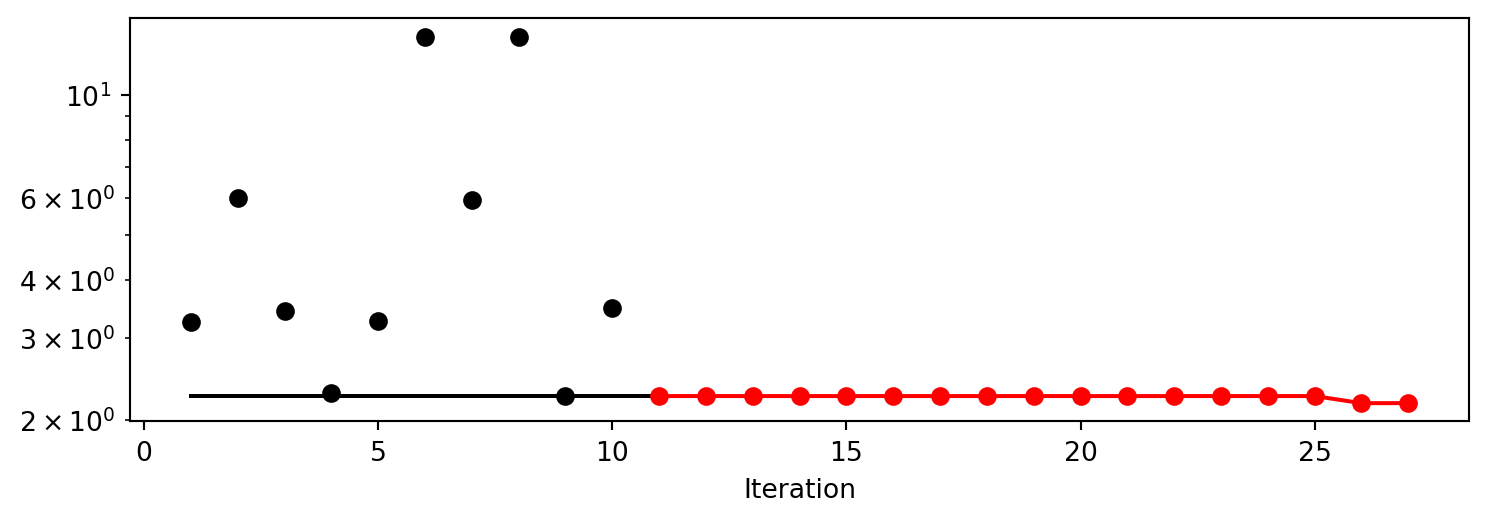

In [19]:
spot_tuner.plot_progress(log_y=True, filename=None)

Results can also be printed in tabular form.


In [20]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                   | type   | default          |   lower |   upper | tuned                 | transform              |   importance | stars   |
|------------------------|--------|------------------|---------|---------|-----------------------|------------------------|--------------|---------|
| grace_period           | int    | 200              |    10.0 |  1000.0 | 369.0                 | None                   |        14.00 | *       |
| max_depth              | int    | 20               |     2.0 |    20.0 | 10.0                  | transform_power_2_int  |         0.01 |         |
| delta                  | float  | 1e-07            |   1e-08 |   1e-06 | 2.687369912822594e-07 | None                   |         0.01 |         |
| tau                    | float  | 0.05             |    0.01 |     0.1 | 0.03965702590085796   | None                   |       100.00 | ***     |
| leaf_prediction        | factor | mean             |     0.0 |     2.0 | model                 | None   

A histogram can be used to visualize the most important hyperparameters.


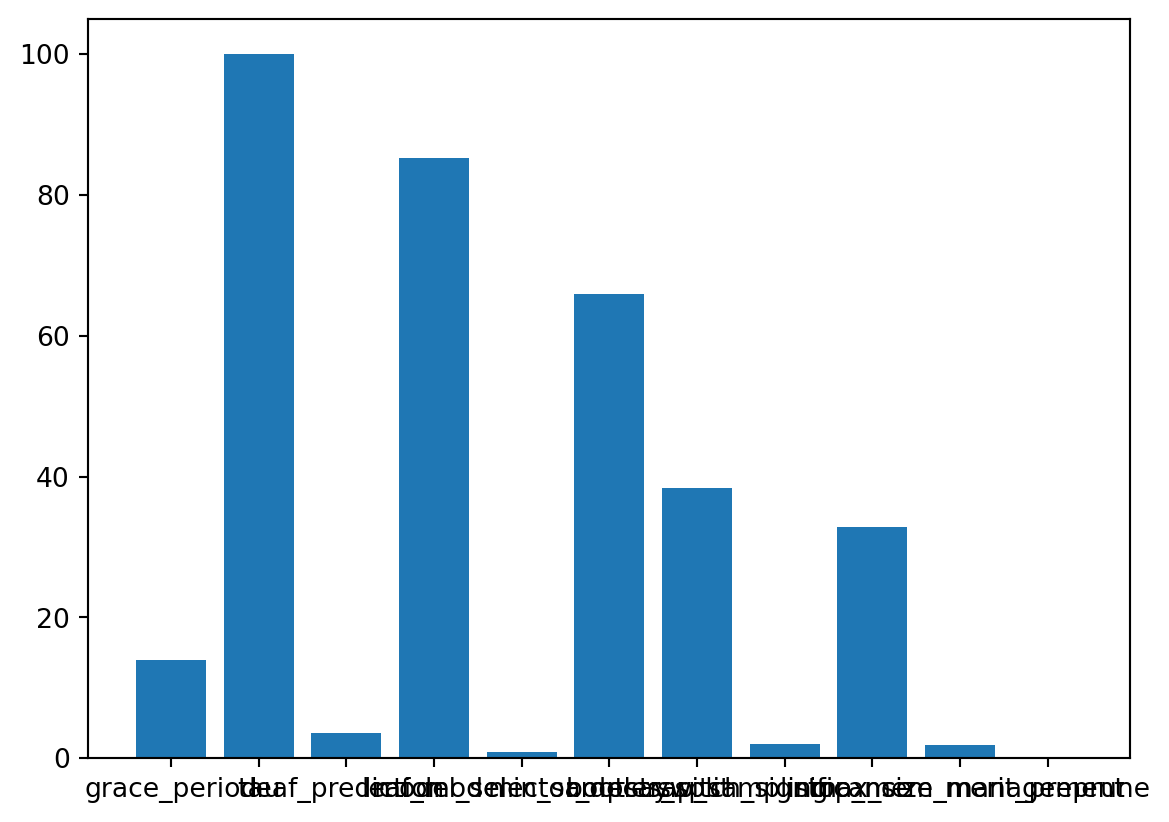

In [21]:
spot_tuner.plot_importance(threshold=0.1)

## Get Default Hyperparameters

The default hyperparameters, which will be used for a comparion with the tuned hyperparameters, can be obtained with the following commands:


In [22]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
model_default = get_one_core_model_from_X(X_start, fun_control, default=True)
model_default

HoeffdingAdaptiveTreeRegressor (
  grace_period=200
  max_depth=1048576
  delta=1e-07
  tau=0.05
  leaf_prediction="mean"
  leaf_model=LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=EBSTSplitter ()
  min_samples_split=5
  bootstrap_sampling=0
  drift_window_threshold=300
  drift_detector=ADWIN (
    delta=0.002
    clock=32
    max_buckets=5
    min_window_length=5
    grace_period=10
  )
  switch_significance=0.05
  binary_split=0
  max_size=500.
  memory_estimate_period=1000000
  stop_mem_management=0
  remove_poor_attrs=0
  merit_preprune=1
  seed=None
)

:::{.callout-note}
#### Note: `spotPython` tunes numpy arrays
* `spotPython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.
::::

The model with the default hyperparameters can be trained and evaluated with the following commands:


In [23]:
from spotRiver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., score (metric), runtime, and memory consumption, can be visualized with the following commands:


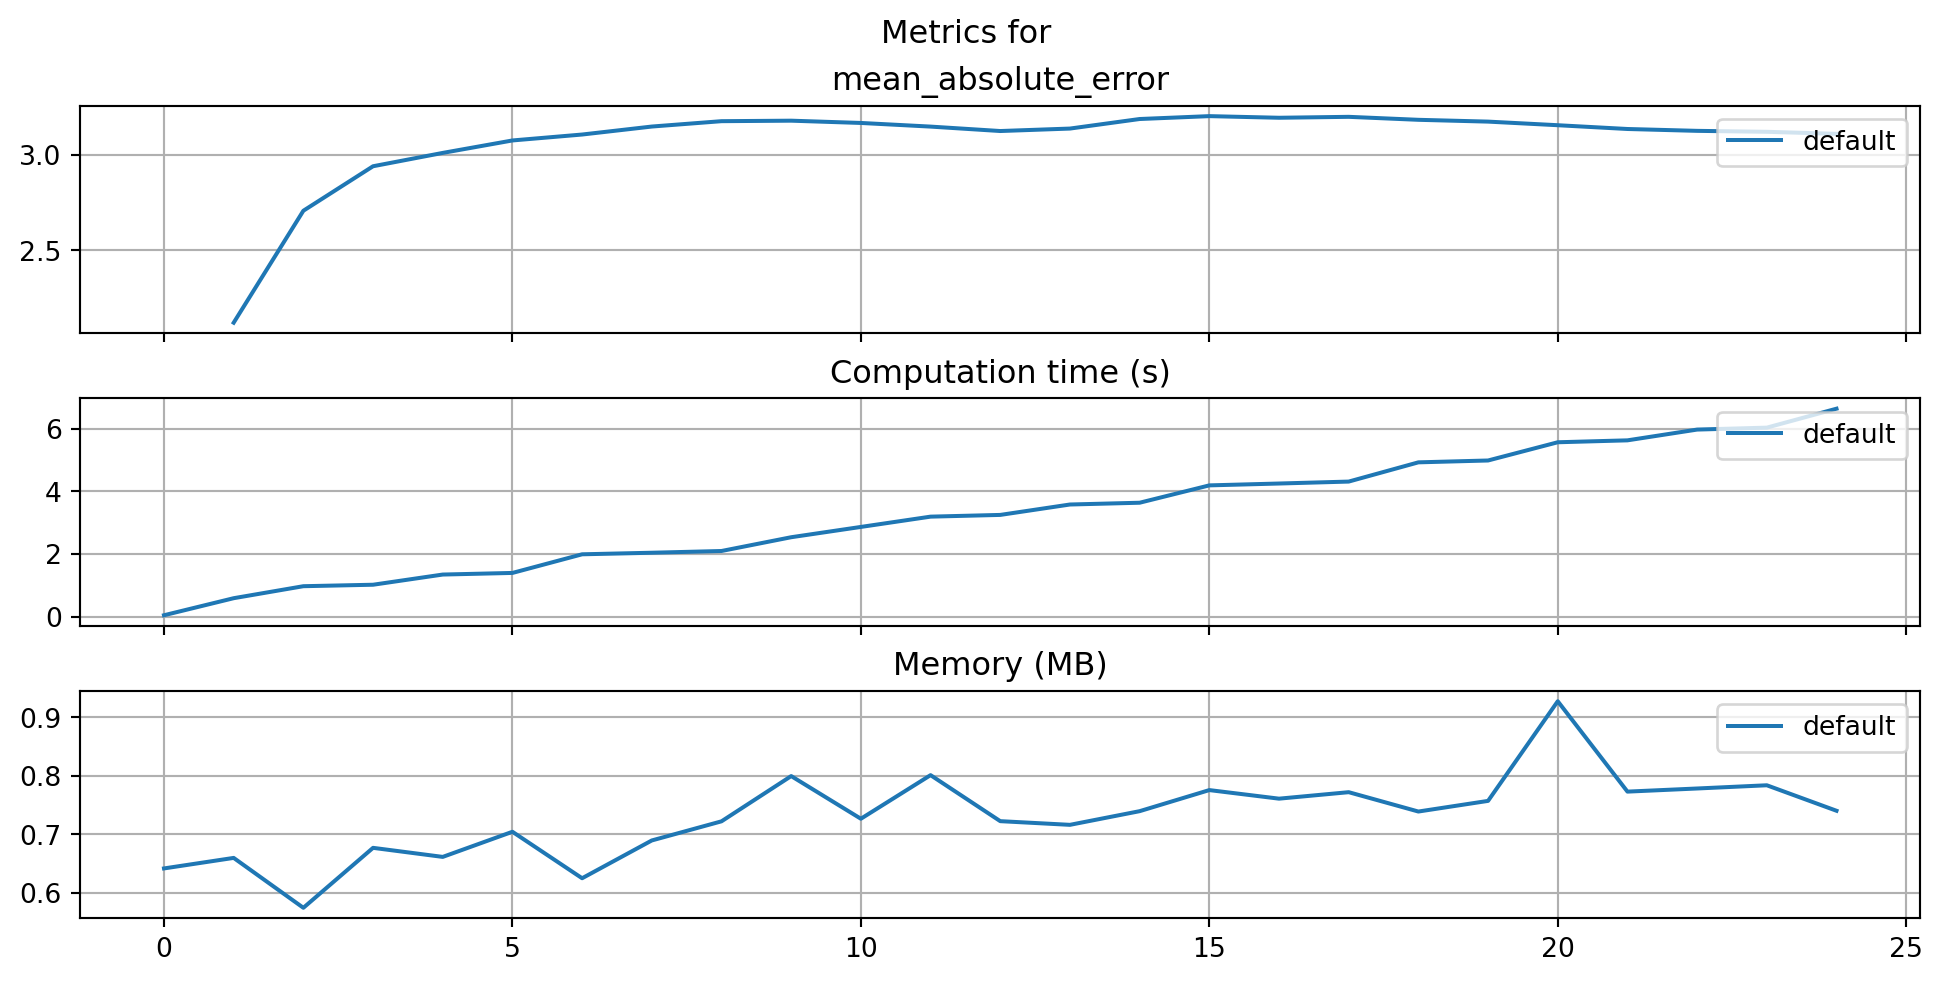

In [24]:
#| label: 024_plot_bml_oml_horizon_metrics_default
from spotRiver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

### Show Predictions

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.


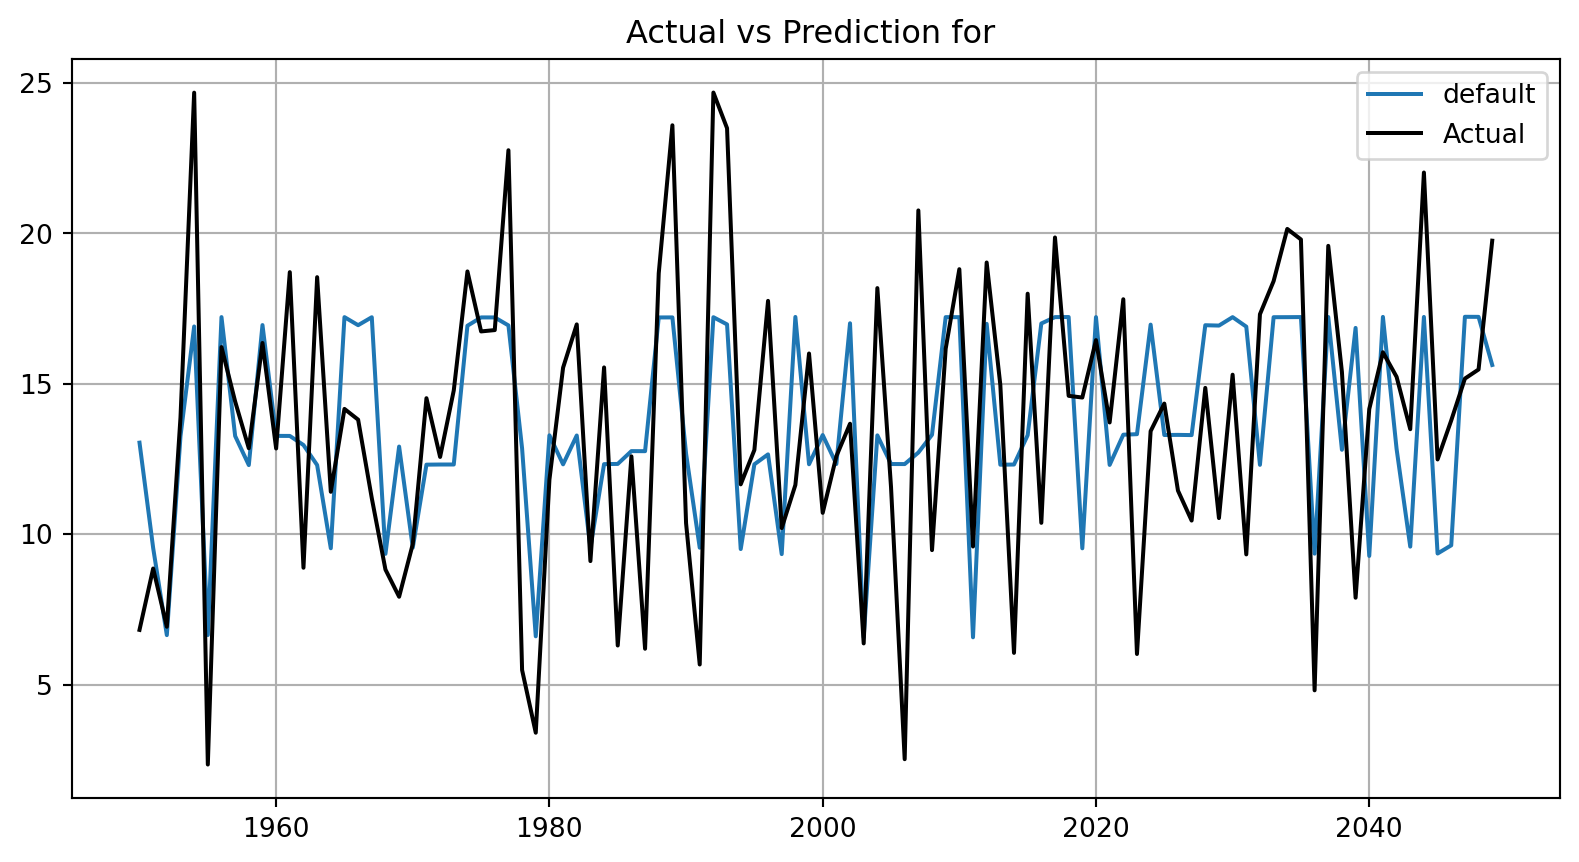

In [25]:
#| label: 024_plot_bml_oml_horizon_predictions_default
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)+50
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotPython`.


In [26]:
#| label: 024_get_one_core_model_from_X
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [27]:
#| label: 024_eval_om_horizon
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

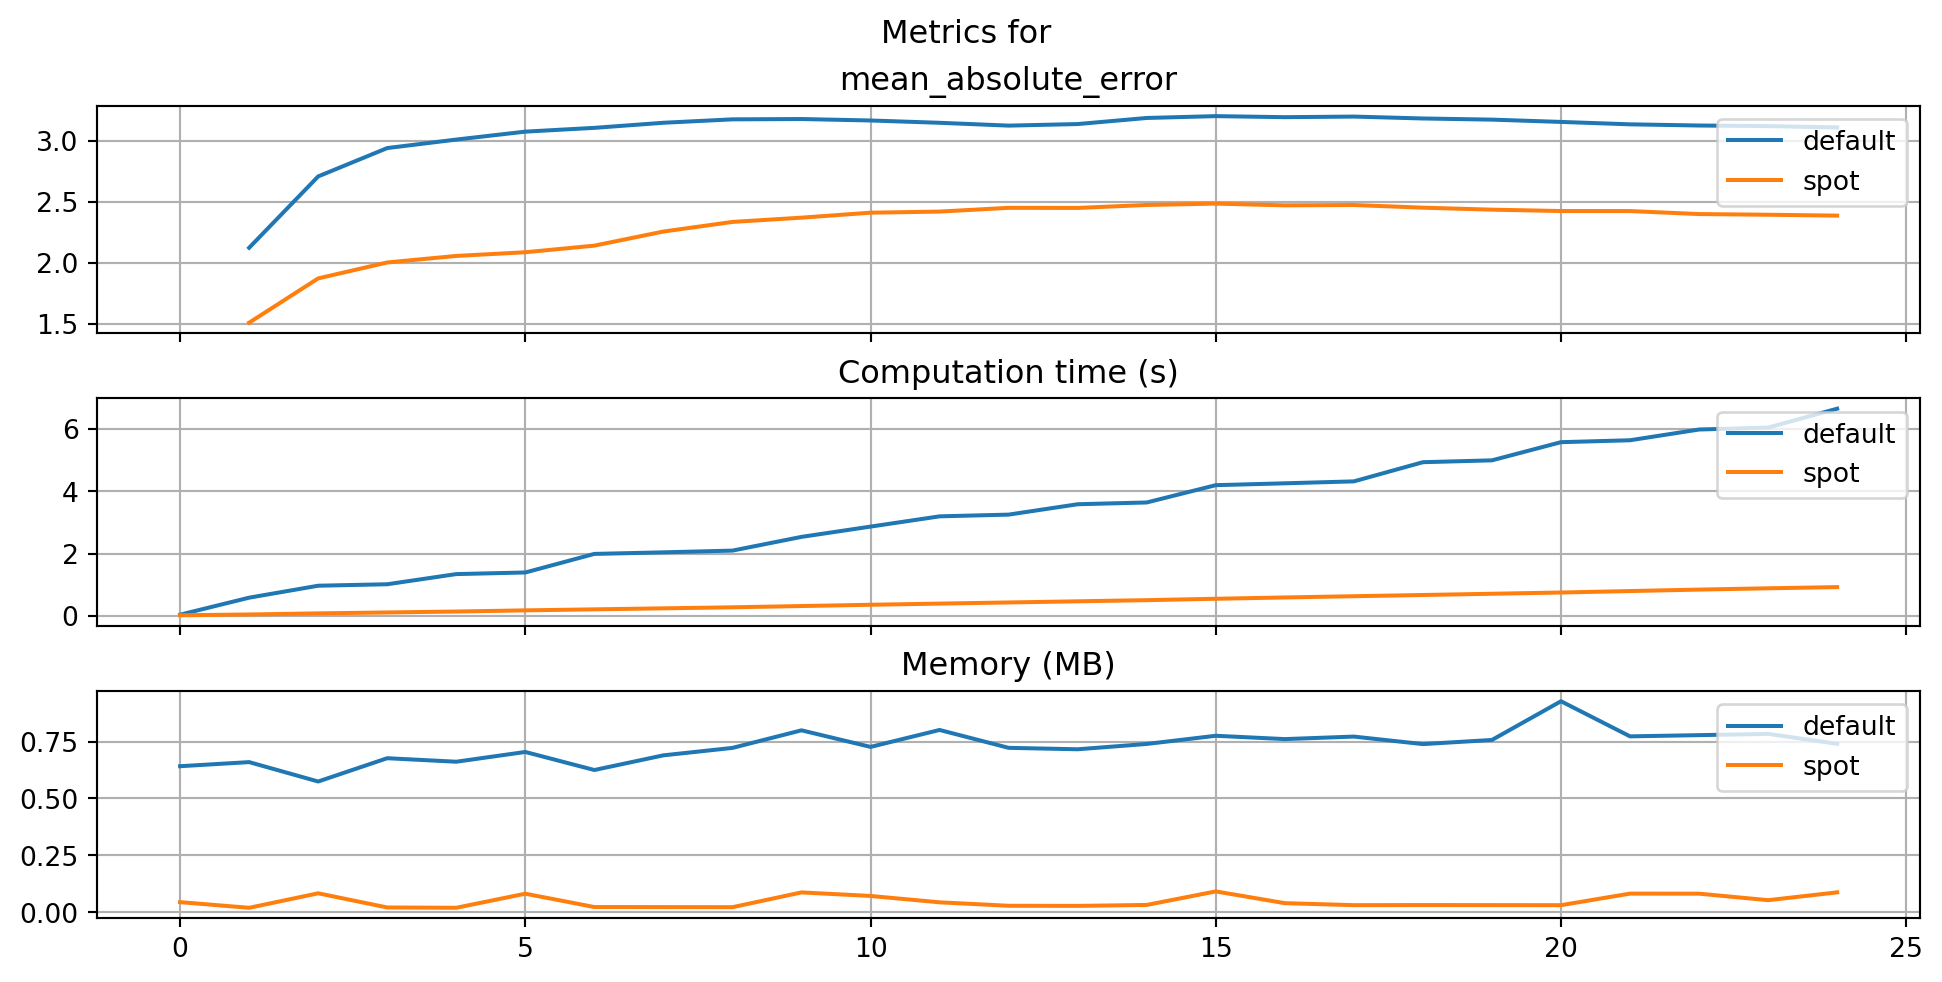

In [28]:
#| label: 024_plot_bml_oml_horizon_metrics
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

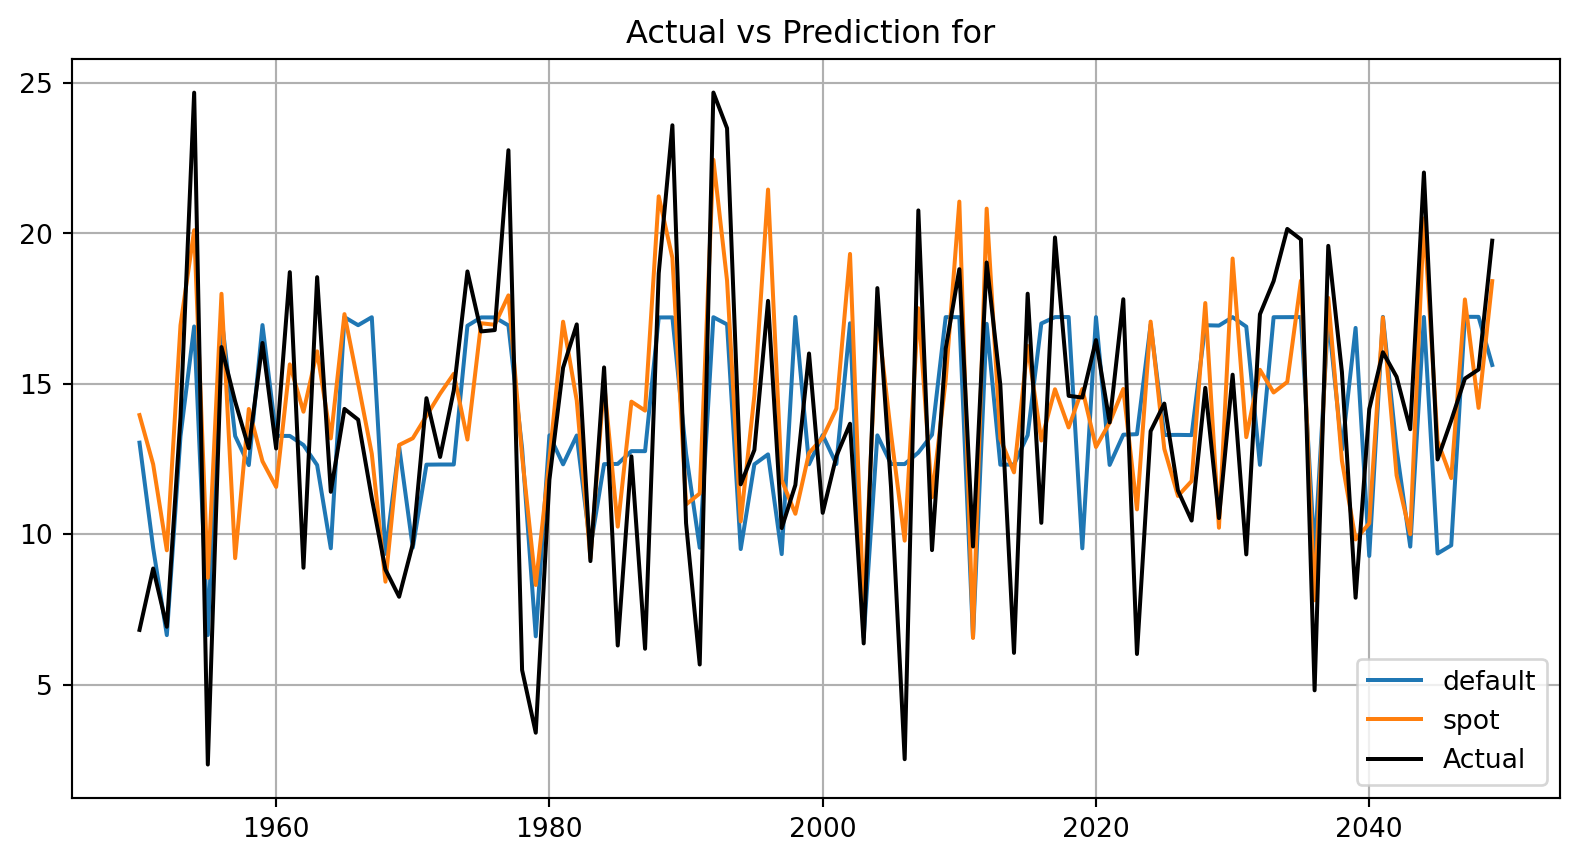

In [29]:
#| label: 024_plot_bml_oml_horizon_predictions
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels)

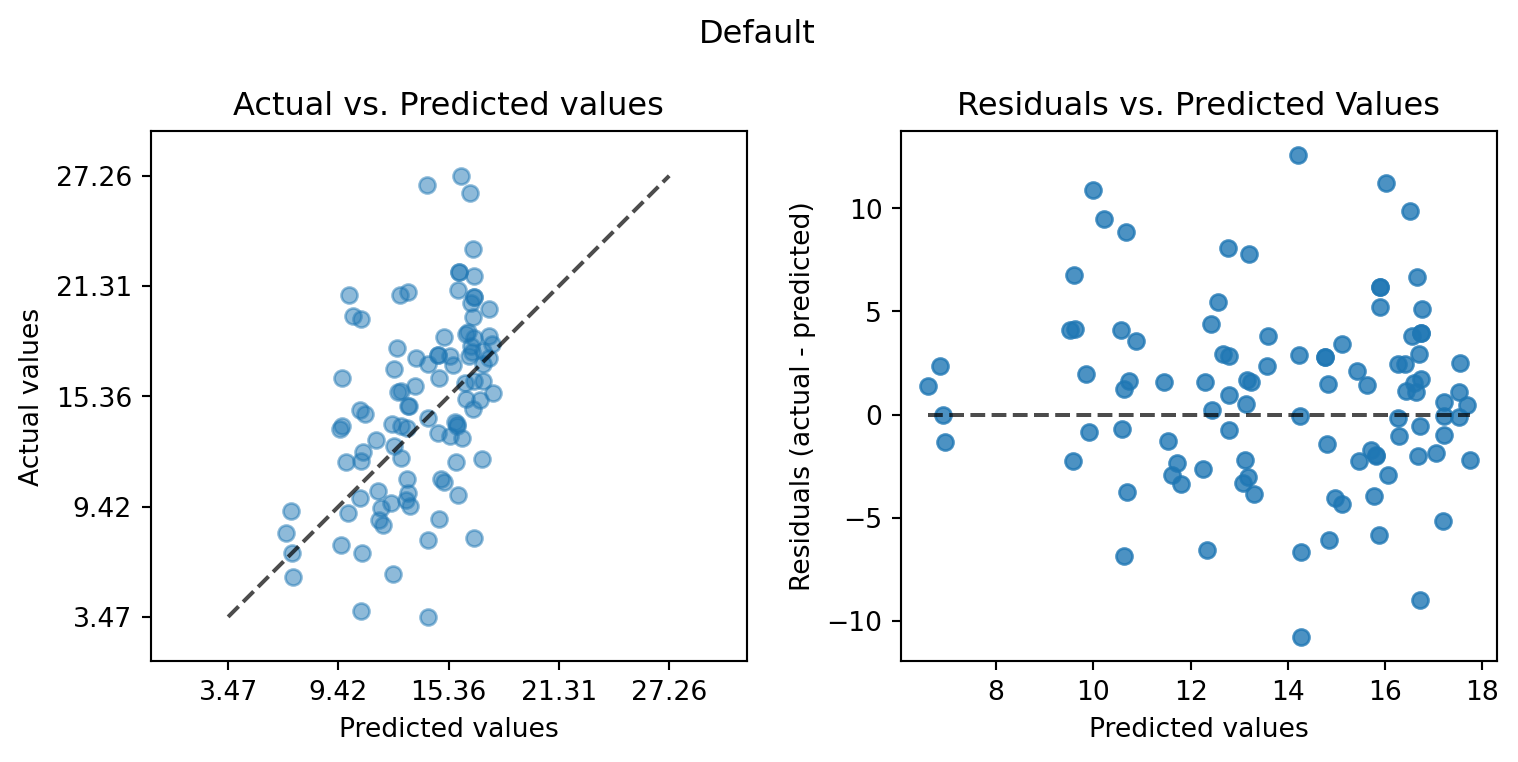

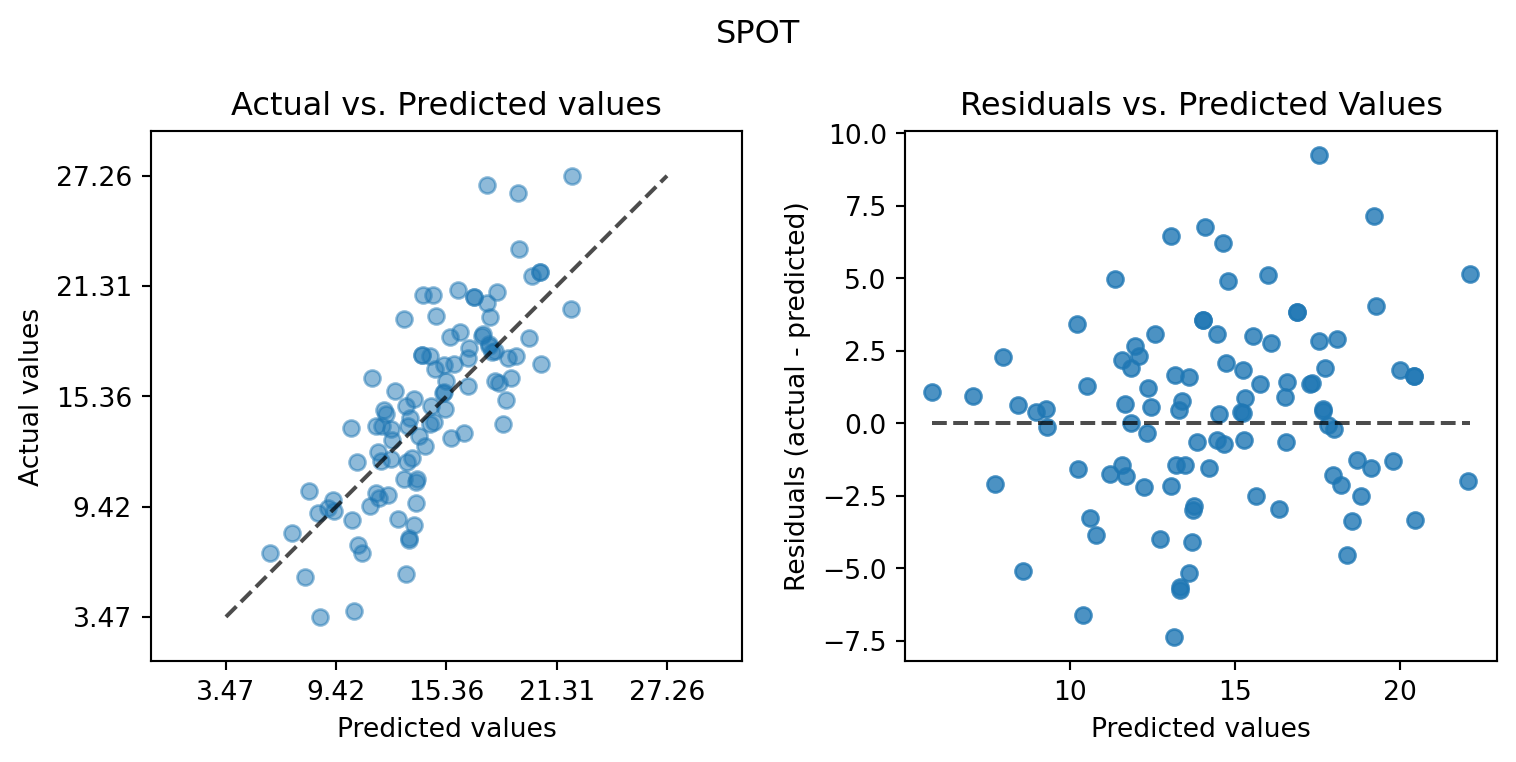

In [30]:
#| label: 024_plot_actual_vs_predicted
from spotPython.plot.validation import plot_actual_vs_predicted
plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Visualize Regression Trees


In [31]:
#| label: 024_model_default_learn_one
dataset_f = dataset.take(n_samples)
print(f"n_samples: {n_samples}")
for x, y in dataset_f:
    model_default.learn_one(x, y)

n_samples: 10000


:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::


In [32]:
# model_default.draw()

In [33]:
#| label: 024_model_default_summary
model_default.summary

{'n_nodes': 45,
 'n_branches': 22,
 'n_leaves': 23,
 'n_active_leaves': 37,
 'n_inactive_leaves': 0,
 'height': 9,
 'total_observed_weight': 14168.0,
 'n_alternate_trees': 4,
 'n_pruned_alternate_trees': 2,
 'n_switch_alternate_trees': 0}

### Spot Model


In [34]:
#| label: 024_model_spot_learn_one
print(f"n_samples: {n_samples}")
dataset_f = dataset.take(n_samples)
for x, y in dataset_f:
    model_spot.learn_one(x, y)

n_samples: 10000


:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::


In [35]:
# model_spot.draw()

In [36]:
#| label: 024_model_spot_summary
model_spot.summary

{'n_nodes': 29,
 'n_branches': 14,
 'n_leaves': 15,
 'n_active_leaves': 25,
 'n_inactive_leaves': 0,
 'height': 6,
 'total_observed_weight': 14168.0,
 'n_alternate_trees': 2,
 'n_pruned_alternate_trees': 1,
 'n_switch_alternate_trees': 0}

In [37]:
#| label: 024_compare_two_tree_models
from spotPython.utils.eda import compare_two_tree_models
print(compare_two_tree_models(model_default, model_spot))

| Parameter                |   Default |   Spot |
|--------------------------|-----------|--------|
| n_nodes                  |        45 |     29 |
| n_branches               |        22 |     14 |
| n_leaves                 |        23 |     15 |
| n_active_leaves          |        37 |     25 |
| n_inactive_leaves        |         0 |      0 |
| height                   |         9 |      6 |
| total_observed_weight    |     14168 |  14168 |
| n_alternate_trees        |         4 |      2 |
| n_pruned_alternate_trees |         2 |      1 |
| n_switch_alternate_trees |         0 |      0 |


## Detailed Hyperparameter Plots


grace_period:  14.003273596561183
max_depth:  0.008893420909658247
delta:  0.00779643859999098
tau:  100.0
leaf_prediction:  3.5140062154588354
leaf_model:  85.31418086809722
model_selector_decay:  0.8674596274256202
splitter:  0.02154647406371429
min_samples_split:  65.94008220387273
bootstrap_sampling:  38.41094805486372
drift_window_threshold:  0.004702562625188429
switch_significance:  1.9893983856587265
binary_split:  0.002356865111162426
max_size:  32.89766188970352
memory_estimate_period:  0.006442788495298308
stop_mem_management:  1.9330561501200645
remove_poor_attrs:  0.003752156649412206
merit_preprune:  0.12072075698753675
impo: [['grace_period', 14.003273596561183], ['max_depth', 0.008893420909658247], ['delta', 0.00779643859999098], ['tau', 100.0], ['leaf_prediction', 3.5140062154588354], ['leaf_model', 85.31418086809722], ['model_selector_decay', 0.8674596274256202], ['splitter', 0.02154647406371429], ['min_samples_split', 65.94008220387273], ['bootstrap_sampling', 38.410

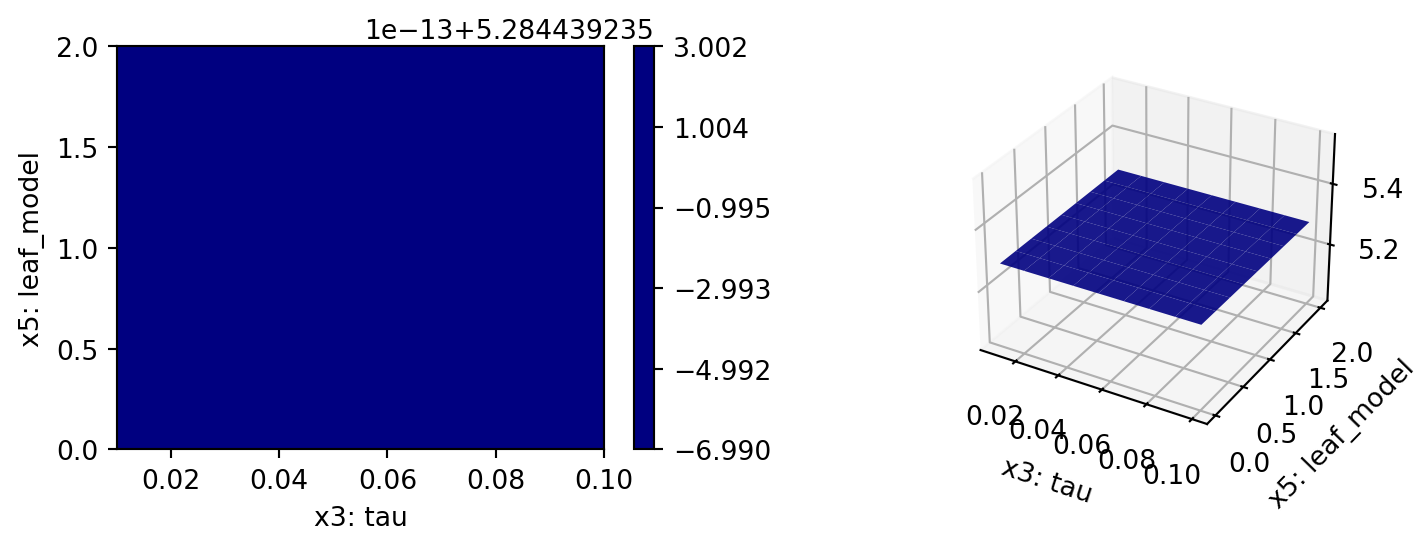

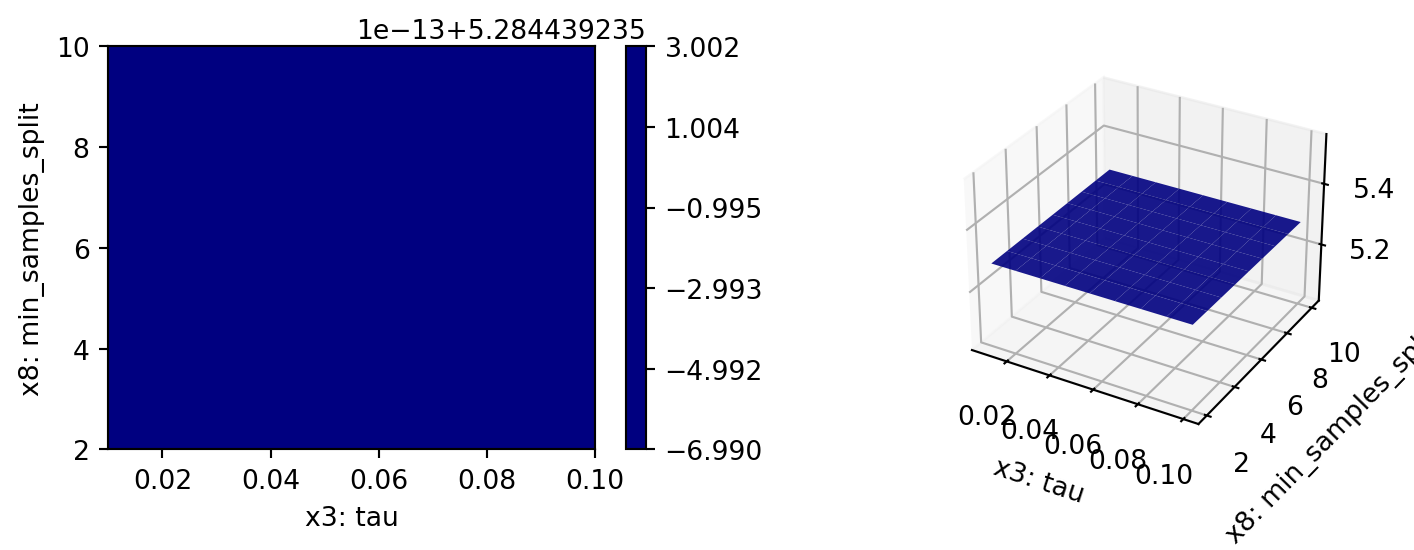

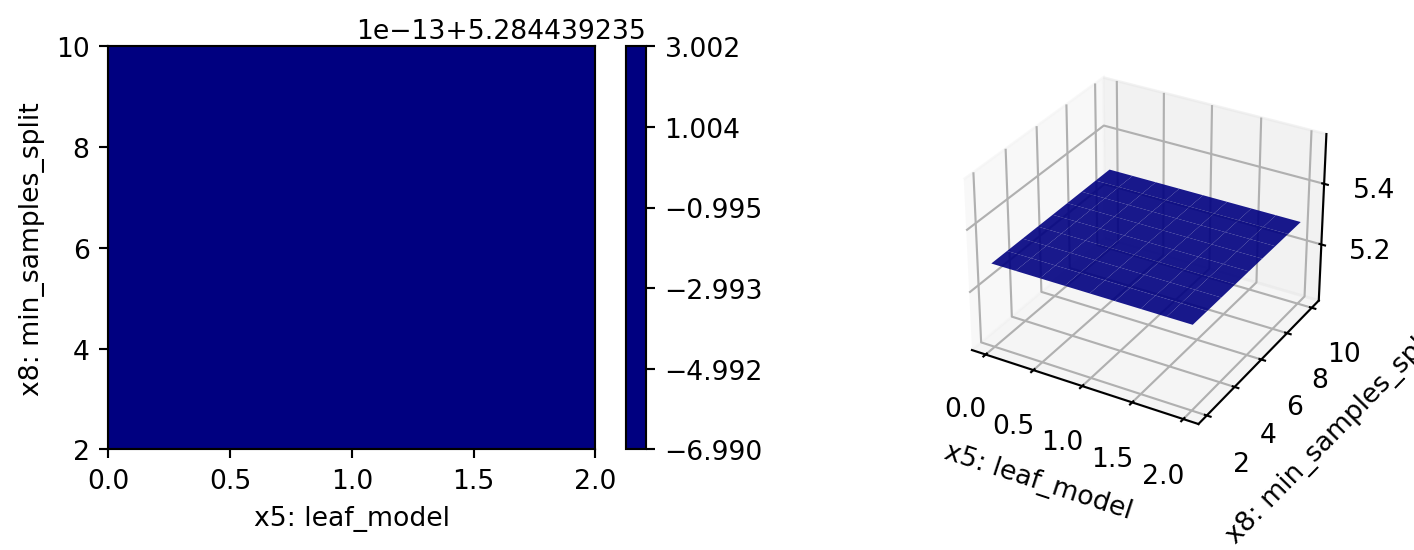

In [38]:
#| label: 024_plot_important_hyperparameter_contour
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

## Parallel Coordinates Plots


In [39]:
#| label: 024_parallel_plot
spot_tuner.parallel_plot()